In [40]:
import pandas as pd
from collections import defaultdict
from sklearn_crfsuite import CRF, metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from itertools import chain
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [13]:
def load_data(path):
    df = pd.read_csv(path, encoding='ISO-8859-1')
    sentences = defaultdict(list)
    for _, row in df.iterrows():
        sent_id = row["Sentence #"]
        word = row["Word"]
        tag = row["Tag"]
        if pd.isnull(sent_id) or pd.isnull(word) or pd.isnull(tag):
            continue
        sentences[sent_id].append((word, tag))
    return list(sentences.values())

data_path = "../data/ner_dataset.csv" 
sentences = load_data(data_path)

In [19]:
rows = []
for sent in sentences:
    for word, tag in sent:
        rows.append((word, tag))
df_flat = pd.DataFrame(rows, columns=['Word', 'Tag'])

In [20]:
print("✅ Total tokens:", len(df_flat))
print("✅ Unique words:", df_flat['Word'].nunique())
print("✅ Unique tags:", df_flat['Tag'].nunique())
print("\n🔎 Tag distribution:\n", df_flat['Tag'].value_counts())

✅ Total tokens: 47949
✅ Unique words: 3797
✅ Unique tags: 9

🔎 Tag distribution:
 Tag
O        34300
B-per     4019
B-geo     3335
B-gpe     2989
B-org     2752
B-tim      515
B-art       18
B-nat       11
B-eve       10
Name: count, dtype: int64


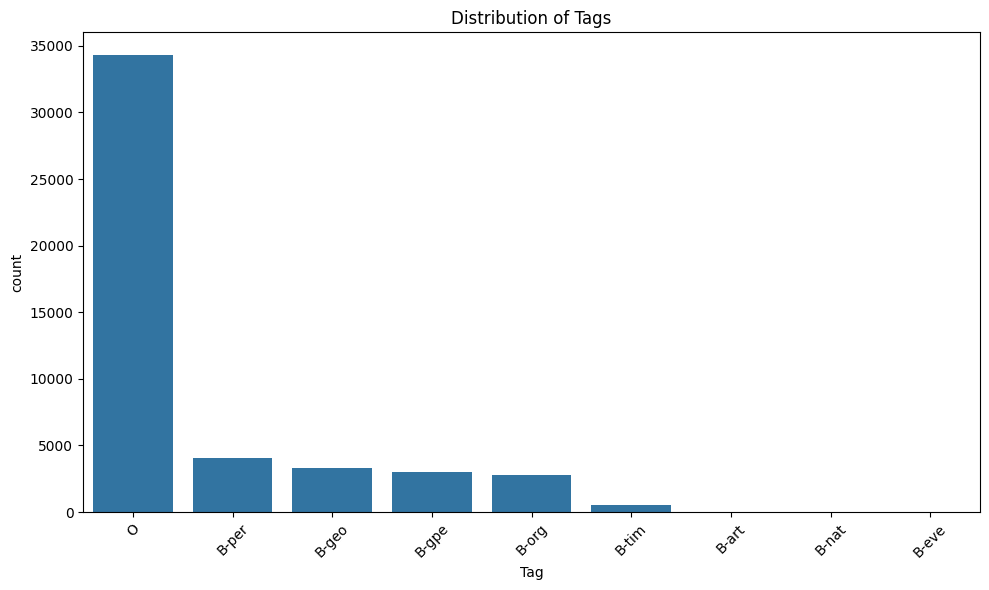

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_flat, x='Tag', order=df_flat['Tag'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribution of Tags")
plt.tight_layout()
plt.show()

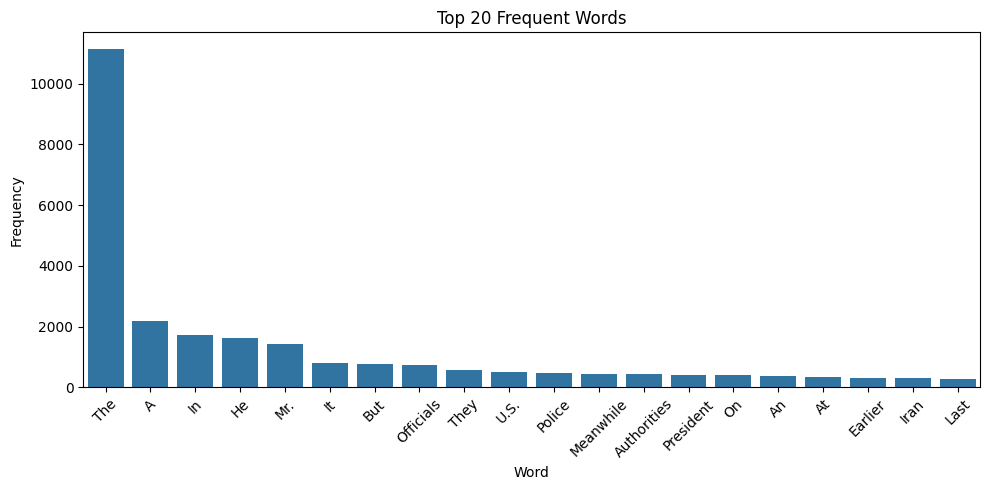

In [18]:
top_words = df_flat['Word'].value_counts().head(20)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_words.index, y=top_words.values)
plt.xticks(rotation=45)
plt.title("Top 20 Frequent Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [24]:
def word2features(sent, i):
    word = str(sent[i][0])
    features = {
        'word': word,
        'is_first': i == 0,
        'lowercase': word.lower(),
        'is_title': word.istitle(),
        'is_upper': word.isupper(),
        'is_digit': word.isdigit(),
        'is_alphanumeric': word.isalnum(),
        'prefix-1': word[:1],
        'prefix-2': word[:2],
        'prefix-3': word[:3],
        'suffix-1': word[-1:],
        'suffix-2': word[-2:],
        'suffix-3': word[-3:],
        'has_hyphen': '-' in word,
        'prev_word': '' if i == 0 else sent[i-1][0],
        'next_word': '' if i == len(sent)-1 else sent[i+1][0],
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word': word1,
            '-1:lower': word1.lower(),
            '-1:is_title': word1.istitle()
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word': word1,
            '+1:lower': word1.lower(),
            '+1:is_title': word1.istitle()
        })
    else:
        features['EOS'] = True
    return features

In [25]:
def prepare_data(sentences):
    X = [[word2features(s, i) for i in range(len(s))] for s in sentences]
    y = [[tag for (_, tag) in s] for s in sentences]
    return X, y

X, y = prepare_data(sentences)

In [26]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 20%

print(f"📊 Train size: {len(X_train)}")
print(f"📊 Validation size: {len(X_val)}")
print(f"📊 Test size: {len(X_test)}")

📊 Train size: 28769
📊 Validation size: 9590
📊 Test size: 9590


In [37]:
def flatten_sequences(X_seq, y_seq):
    X_flat = list(chain.from_iterable(X_seq))
    y_flat = list(chain.from_iterable(y_seq))
    return X_flat, y_flat

X_train_flat, y_train_flat = flatten_sequences(X_train, y_train)
X_val_flat, y_val_flat = flatten_sequences(X_val, y_val)
X_test_flat, y_test_flat = flatten_sequences(X_test, y_test)


In [38]:
vectorizer = DictVectorizer(sparse=True)
X_train_vec = vectorizer.fit_transform(X_train_flat)
X_val_vec = vectorizer.transform(X_val_flat)
X_test_vec = vectorizer.transform(X_test_flat)


In [39]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_vec, y_train_flat)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


c:\Users\kanha\Desktop\Sap_assignment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kanha\Desktop\Sap_assignment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kanha\Desktop\Sap_assignment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize


📋 VALIDATION Classification Report:

              precision    recall  f1-score   support

       B-art     0.0000    0.0000    0.0000         5
       B-eve     0.0000    0.0000    0.0000         1
       B-geo     0.7809    0.8808    0.8279       688
       B-gpe     0.9408    0.9045    0.9223       597
       B-nat     1.0000    1.0000    1.0000         1
       B-org     0.7301    0.5379    0.6194       528
       B-per     0.8629    0.8395    0.8511       810
       B-tim     0.9459    0.7143    0.8140        98
           O     0.9692    0.9870    0.9781      6862

    accuracy                         0.9337      9590
   macro avg     0.6922    0.6516    0.6681      9590
weighted avg     0.9310    0.9337    0.9310      9590


🎯 Weighted F1 Score (VALIDATION): 0.9310


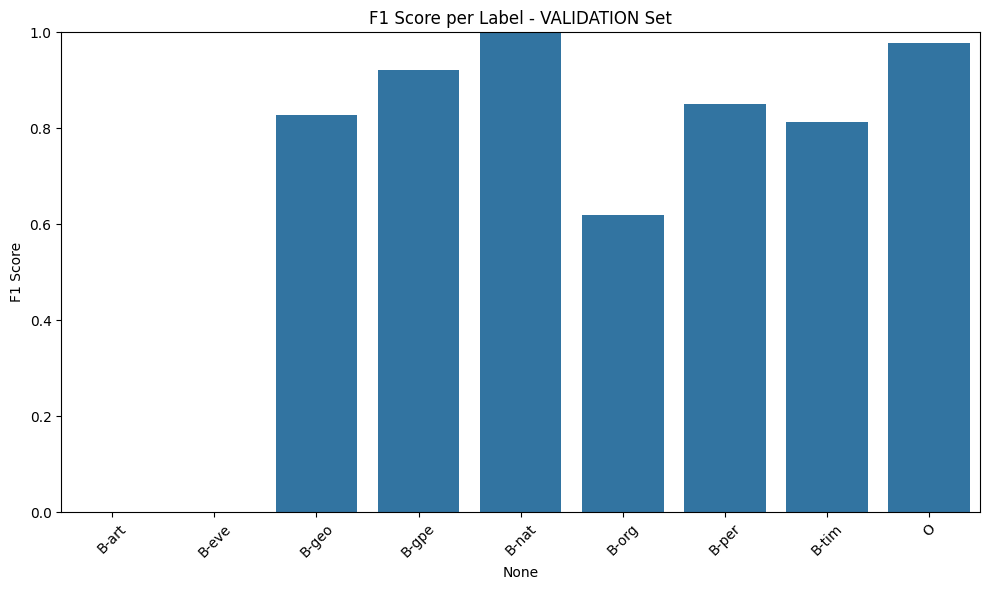

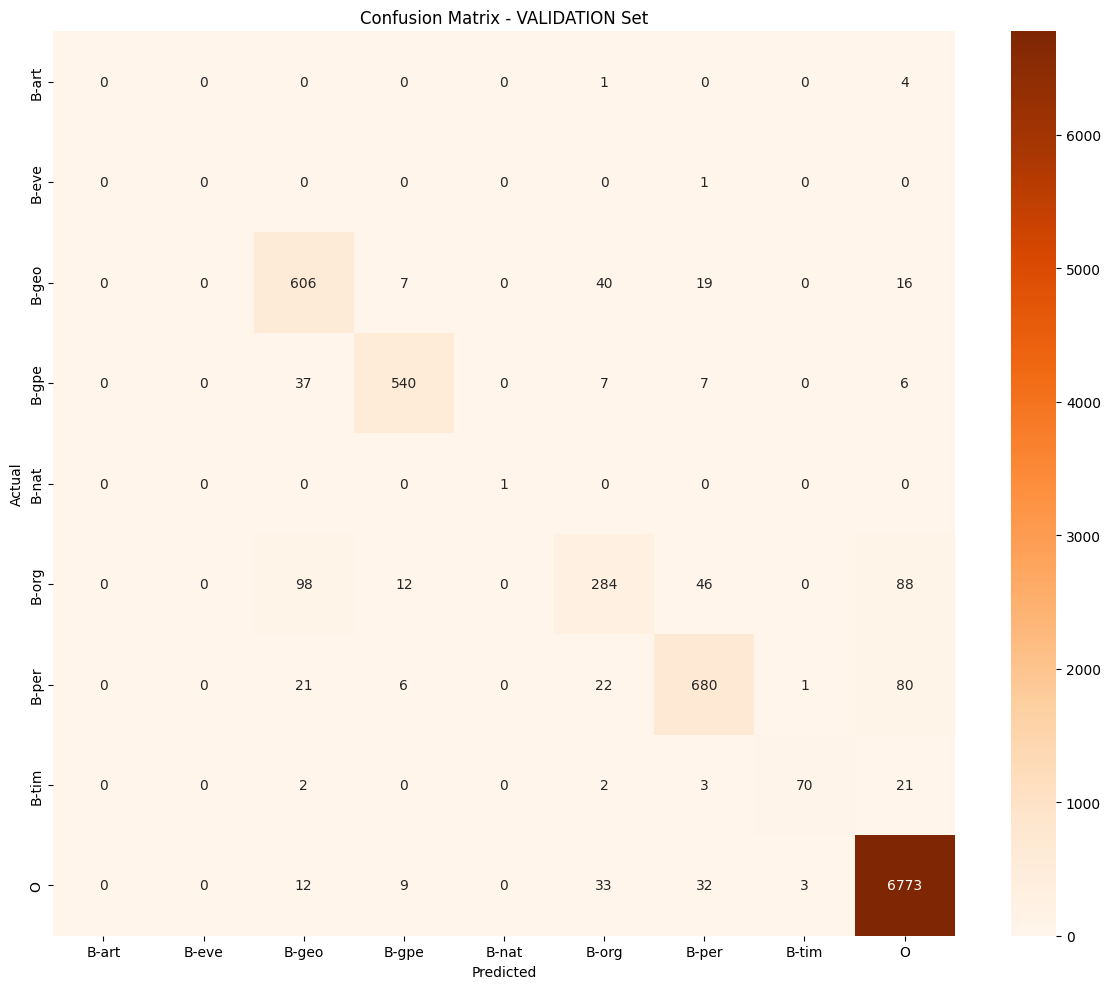

c:\Users\kanha\Desktop\Sap_assignment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kanha\Desktop\Sap_assignment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kanha\Desktop\Sap_assignment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize


📋 TEST Classification Report:

              precision    recall  f1-score   support

       B-art     0.0000    0.0000    0.0000         3
       B-geo     0.7433    0.8660    0.8000       709
       B-gpe     0.9452    0.8785    0.9106       609
       B-nat     1.0000    0.6667    0.8000         3
       B-org     0.7300    0.5009    0.5942       529
       B-per     0.8720    0.8314    0.8513       795
       B-tim     0.9420    0.7065    0.8075        92
           O     0.9673    0.9893    0.9782      6850

    accuracy                         0.9300      9590
   macro avg     0.7750    0.6799    0.7177      9590
weighted avg     0.9278    0.9300    0.9270      9590


🎯 Weighted F1 Score (TEST): 0.9270


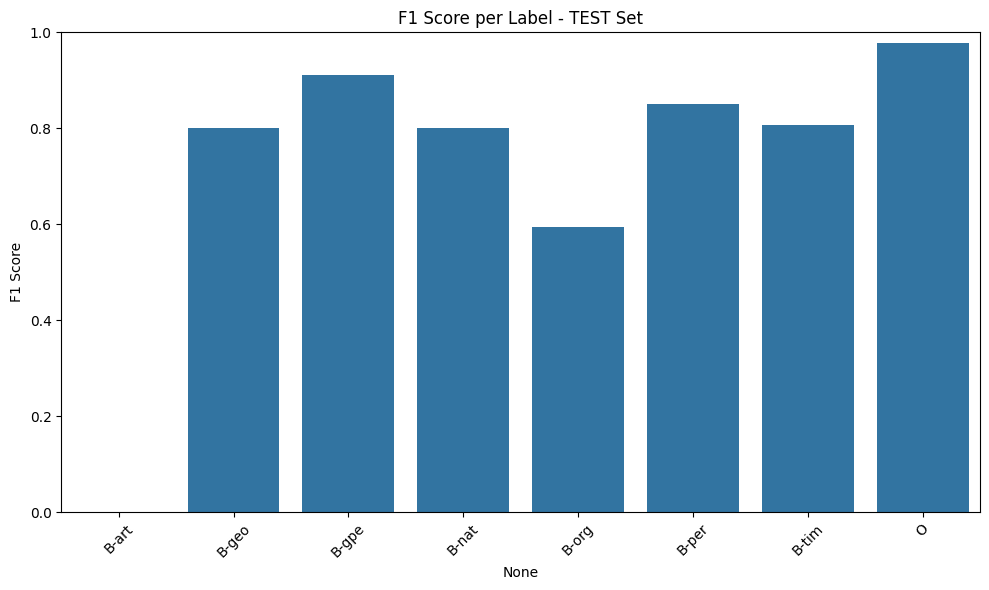

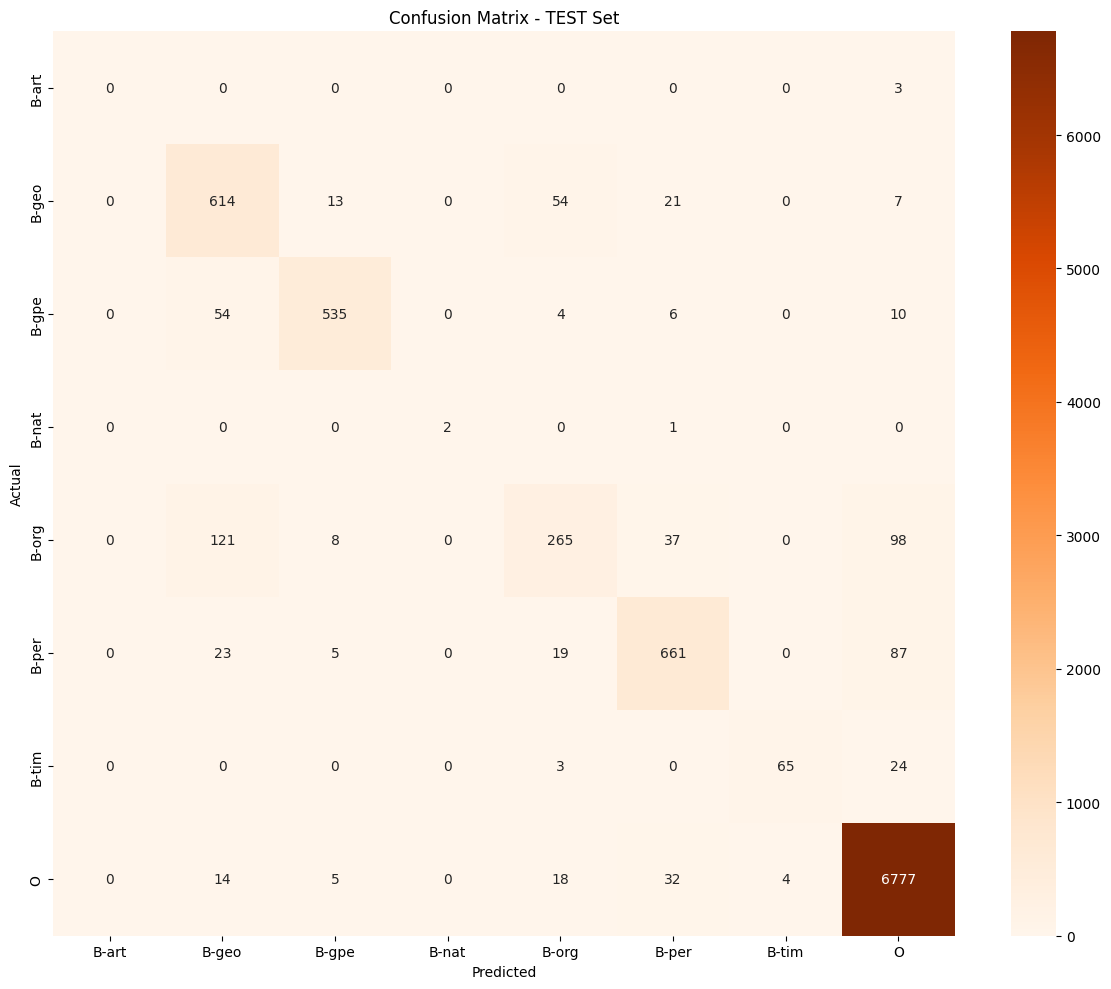

In [41]:
def evaluate_model(model, X_vec, y_true, tag='Test'):
    y_pred = model.predict(X_vec)

    labels = sorted(list(set(y_true)))
    report_dict = classification_report(y_true, y_pred, labels=labels, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose().drop("accuracy", errors="ignore")

    print(f"\n📋 {tag.upper()} Classification Report:\n")
    print(classification_report(y_true, y_pred, labels=labels, digits=4))

    # Weighted F1 Score
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"\n🎯 Weighted F1 Score ({tag.upper()}): {weighted_f1:.4f}")

    # 📊 F1 Score per Label Plot
    f1_per_label = report_df['f1-score'].drop('macro avg', errors="ignore").drop('weighted avg', errors="ignore")
    plt.figure(figsize=(10, 6))
    sns.barplot(x=f1_per_label.index, y=f1_per_label.values)
    plt.xticks(rotation=45)
    plt.title(f"F1 Score per Label - {tag.upper()} Set")
    plt.ylabel("F1 Score")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    # 🔍 Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred, labels=labels)
    conf_df = pd.DataFrame(conf_mat, index=labels, columns=labels)

    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_df, annot=True, fmt='d', cmap='Oranges')
    plt.title(f"Confusion Matrix - {tag.upper()} Set")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

    return report_df, weighted_f1


val_report, val_f1 = evaluate_model(lr_model, X_val_vec, y_val_flat, tag="Validation")
test_report, test_f1 = evaluate_model(lr_model, X_test_vec, y_test_flat, tag="Test")

## ***Advance Model***

In [27]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)
print("✅ Model training complete")

✅ Model training complete


In [32]:
from sklearn_crfsuite import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_model(crf, X, y, label_list=None, tag='eval'):
    y_pred = crf.predict(X)
    
    print(f"\n📋 {tag.upper()} Classification Report:\n")
    report = metrics.flat_classification_report(y, y_pred, labels=label_list, digits=4)
    print(report)

    # Weighted F1 score
    weighted_f1 = metrics.flat_f1_score(y, y_pred, average='weighted', labels=label_list)
    print(f"\n📊 Weighted F1 Score ({tag.upper()}): {weighted_f1:.4f}")

    # Per-label F1 scores (dictionary)
    f1_scores = metrics.flat_f1_score(y, y_pred, average=None, labels=label_list)
    f1_per_label = dict(zip(label_list, f1_scores))

    # 📊 Plot: F1 per label
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(f1_per_label.keys()), y=list(f1_per_label.values()))
    plt.xticks(rotation=45)
    plt.title(f"F1 Score per Label - {tag.upper()} Set")
    plt.ylabel("F1 Score")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    # 📊 Confusion Matrix (flattened)
    y_true_flat = [item for sublist in y for item in sublist]
    y_pred_flat = [item for sublist in y_pred for item in sublist]
    conf_df = pd.crosstab(pd.Series(y_true_flat, name='Actual'), pd.Series(y_pred_flat, name='Predicted'))

    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {tag.upper()} Set")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

    # 📋 Comparison table with all metrics
    report_dict = metrics.flat_classification_report(y, y_pred, labels=label_list, digits=4, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    report_df = report_df.drop(["accuracy"], errors="ignore")  # drop accuracy row if present

    return report_df, weighted_f1, f1_per_label


🔎 Evaluating on Validation Set

📋 VAL Classification Report:

              precision    recall  f1-score   support

           O     0.9739    0.9851    0.9795      6862
       B-gpe     0.9390    0.9028    0.9206       597
       B-org     0.7098    0.5511    0.6205       528
       B-geo     0.7799    0.8808    0.8273       688
       B-per     0.8533    0.8543    0.8538       810
       B-tim     0.9459    0.7143    0.8140        98
       B-art     0.0000    0.0000    0.0000         5
       B-eve     0.0000    0.0000    0.0000         1
       B-nat     1.0000    1.0000    1.0000         1

    accuracy                         0.9342      9590
   macro avg     0.6891    0.6543    0.6684      9590
weighted avg     0.9322    0.9342    0.9322      9590


📊 Weighted F1 Score (VAL): 0.9322


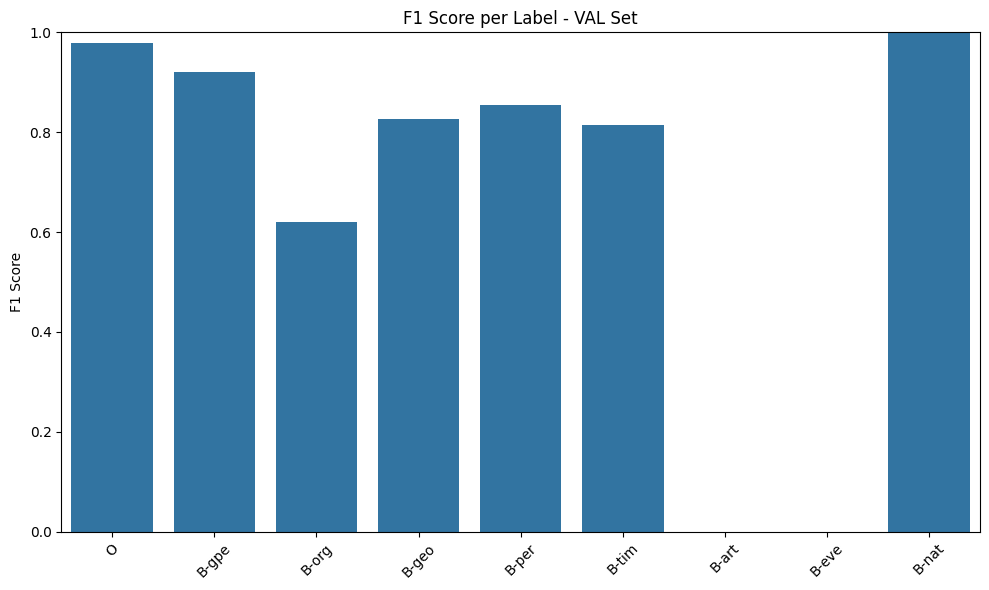

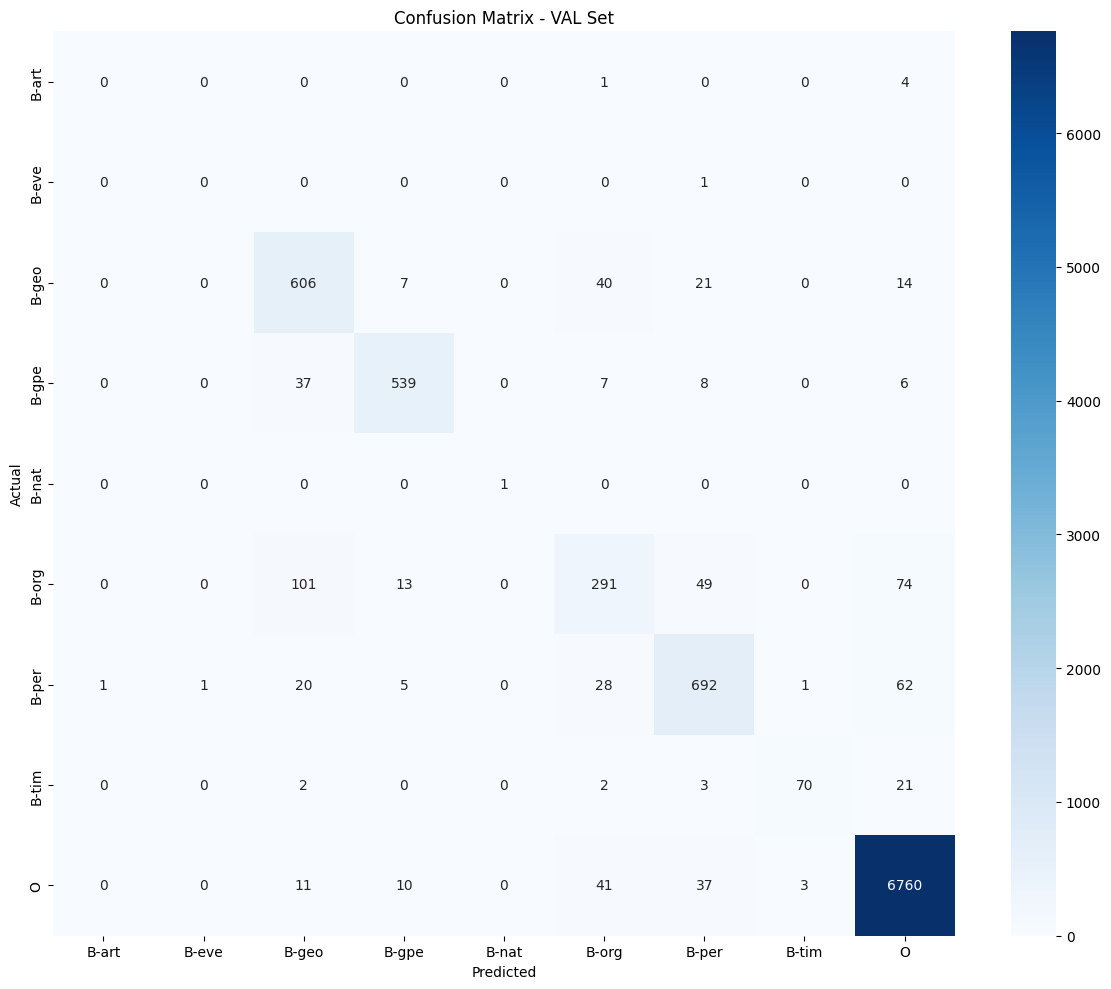

🔎 Evaluating on Test Set

📋 TEST Classification Report:

              precision    recall  f1-score   support

           O     0.9716    0.9876    0.9795      6850
       B-gpe     0.9419    0.8785    0.9091       609
       B-org     0.7165    0.5161    0.6000       529
       B-geo     0.7436    0.8590    0.7971       709
       B-per     0.8626    0.8528    0.8577       795
       B-tim     0.9286    0.7065    0.8025        92
       B-art     0.0000    0.0000    0.0000         3
       B-eve     0.0000    0.0000    0.0000         0
       B-nat     1.0000    0.6667    0.8000         3

    accuracy                         0.9309      9590
   macro avg     0.6850    0.6075    0.6384      9590
weighted avg     0.9290    0.9309    0.9285      9590


📊 Weighted F1 Score (TEST): 0.9285


c:\Users\kanha\Desktop\Sap_assignment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kanha\Desktop\Sap_assignment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kanha\Desktop\Sap_assignment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

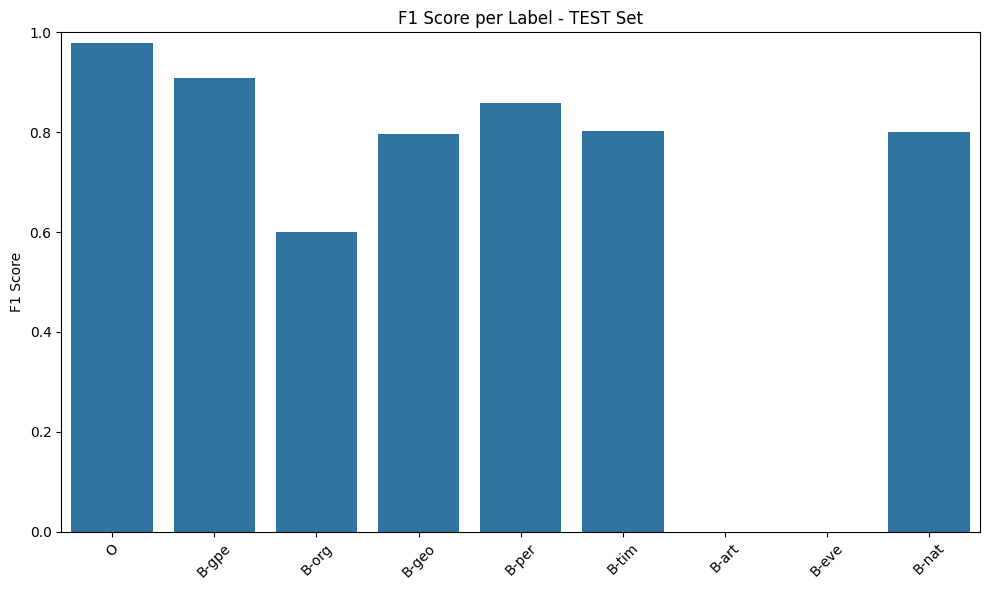

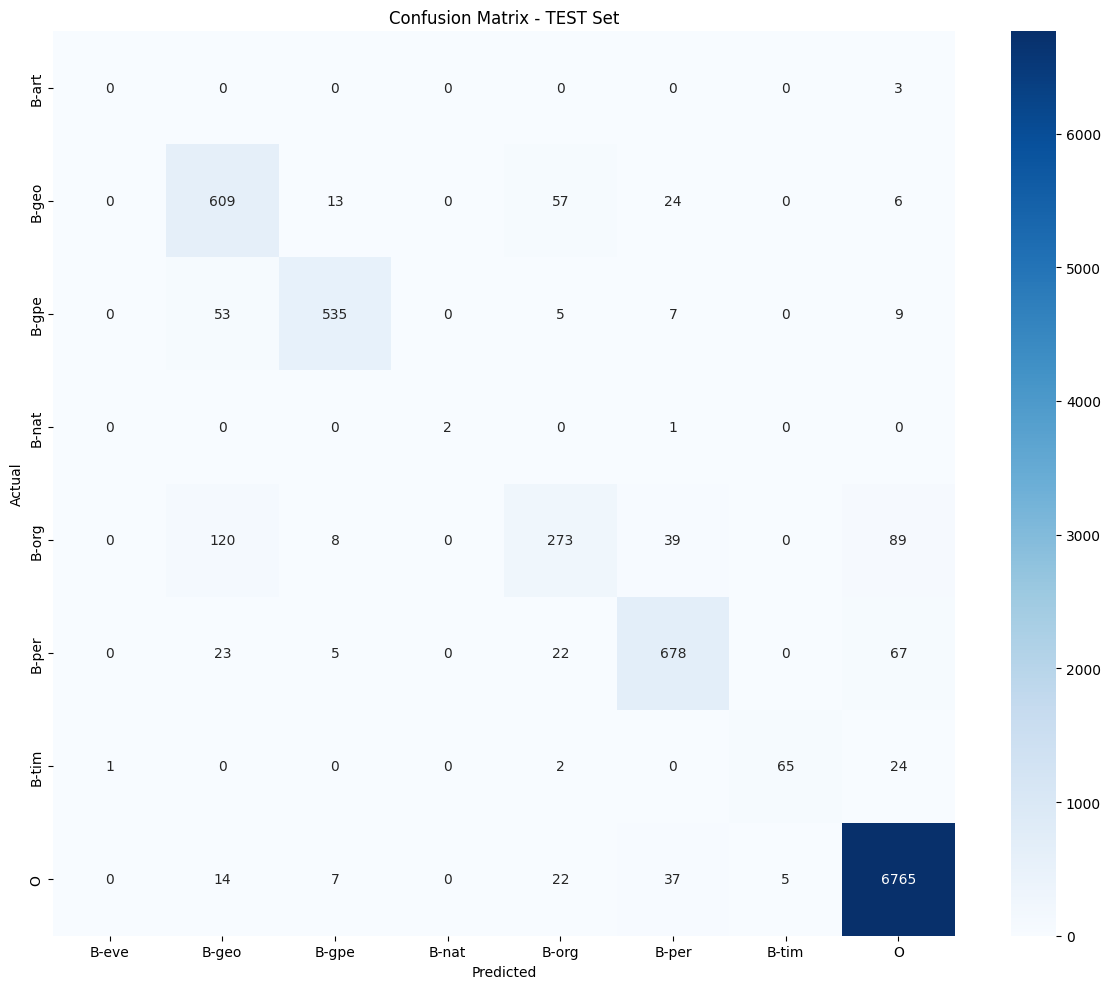

c:\Users\kanha\Desktop\Sap_assignment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kanha\Desktop\Sap_assignment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kanha\Desktop\Sap_assignment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [33]:
print("🔎 Evaluating on Validation Set")
val_report_df, val_f1_weighted, val_f1_per_label = evaluate_model(crf, X_val, y_val, label_list=crf.classes_, tag='val')

print("🔎 Evaluating on Test Set")
test_report_df, test_f1_weighted, test_f1_per_label = evaluate_model(crf, X_test, y_test, label_list=crf.classes_, tag='test')
